In [5]:
using CSV
using DataFrames
using Plots

In [42]:
df = CSV.read("data/grid/npcc_new.csv", DataFrame);

In [45]:
size(df)

(46, 21)

In [44]:
length(Matrix(df))

966

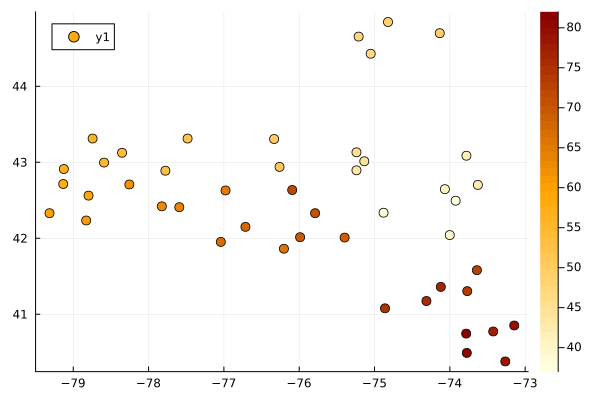

In [ ]:
plot(df.xcoord, df.ycoord, 
    zcolor = df.busIdx,
    seriestype = :scatter,
    markersize=5,
    color = palette(:heat, size(df)[1]))

In [40]:
# Solar generator info
solargen = zeros(10, 21)

solargen[:, 1] .= 11 # Bus number
solargen[:, 2] .= 0 # Pg
solargen[:, 3] .= 0 # Qg
solargen[:, 4] .= 9999 # Qmax
solargen[:, 5] .= -9999 # Qmin
solargen[:, 6] .= 1 # Vg
solargen[:, 7] .= 100 # mBase
solargen[:, 8] .= 1 # status
solargen[:, 9] .= 0 # Pmax
solargen[:, 10] .= 0 # Pmin
solargen[:, 11] .= 0 # Pc1
solargen[:, 12] .= 0 # Pc2
solargen[:, 13] .= 0 # Qc1min
solargen[:, 14] .= 0 # Qc1max
solargen[:, 15] .= 0 # Qc2min
solargen[:, 16] .= 0 # Qc2max
solargen[:, 17] .= Inf # ramp rate for load following/AGC
solargen[:, 18] .= Inf # ramp rate for 10 minute reserves
solargen[:, 19] .= Inf # ramp rate for 30 minute reserves
solargen[:, 20] .= 0 # ramp rate for reactive power
solargen[:, 21] .= 0 # area participation factor

10-element view(::Matrix{Float64}, :, 21) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [41]:
x

10×21 Matrix{Float64}:
 101.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0

In [39]:
x = solargen

10×21 Matrix{Float64}:
 101.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 101.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0

In [36]:
x = copy(solargen)

10×21 Matrix{Float64}:
 10.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0

In [32]:
x

10×21 Matrix{Float64}:
 10.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0  …  0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0
 10.0  0.0  0.0  9999.0  -9999.0  1.0     0.0  0.0  Inf  Inf  Inf  0.0  0.0